# A Gentle Introduction to Time Series Analyis

This notebook provides an End-to-End Time Series pipeline. 

The pipeline covers basic time series analysis concepts:
- **Time Series Visualization** - Lineplot / Scatterplot
- **Time Series Components**
    - Trend, Seasonality & Noise
    - Stationarity
    - Self-correlation
- **Data Wrangling**
    - Resampling
    - Noise Reduction
- **Time Series Forecasting** - AR + MA + ARIMA
- **Feature Generation using Time Series** - Generate features for your Machine Learning model


All background concepts were covered at the [Analytics Vidhya DataHour lecture](https://docs.google.com/presentation/d/1T2RNXirziEr35_OGOYK_JCmmVOEau5hk3XMG5GxZYMo/edit?usp=sharing) by Miguel Cacho Soblechero, PhD

# 0. Requirements

### Download and import packages

In [1]:
# Install and Import Necessary Libraries
!pip install statsmodels
!pip install pandas


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Download dataset

In [3]:
# Load the AirPassengers Dataset
# AirPassengers = sm.datasets.get_rdataset("AirPassengers").data
air_passengers = pd.read_csv("AirPassengers.csv").rename(
    {"Month": "date", "#Passengers": "num_passengers"}, axis=1
)
air_passengers["date"] = pd.to_datetime(air_passengers["date"])
air_passengers.head()

,date,num_passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


# 1. Time Series Visualization

The evolution of the values with time is usually visualized using either a **lineplot** or a **scatterplot**. 

The **lineplot** creates a "cleaner" view of the evolution of values with time. This is done by connecting every point with the adjacent with a line. However, if your data has missing intervals, it might create misleading visual artifacts.

The **scatterplot** avoids this problem by plotting the raw values with their corresponding timestamp, without establishing relationships between points. However, this makes it harder to interpreted.

In [54]:
# Plotting functions
def plot_lineplot_time_series(data: pd.DataFrame, x: str, y: str):
    # Basic plotting
    plt.figure(figsize=(15, 5))
    sns.lineplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)


def plot_scatter_time_series(data: pd.DataFrame, x: str, y: str):
    # Basic plotting
    plt.figure(figsize=(15, 5))
    sns.scatterplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)


def plot_lineplot_two_timeseries(
    data_original: pd.DataFrame,
    x_original: str,
    y_original: str,
    data_processed: pd.DataFrame,
    x_processed: str,
    y_processed: str,
):
    # Basic plotting
    plt.figure(figsize=(15, 5))
    sns.lineplot(data=data_original, x=x_original, y=y_original, label="Original")
    sns.lineplot(data=data_processed, x=x_processed, y=y_processed, label="Processed")

    # Format tick labels
    plt.xticks(rotation=45)

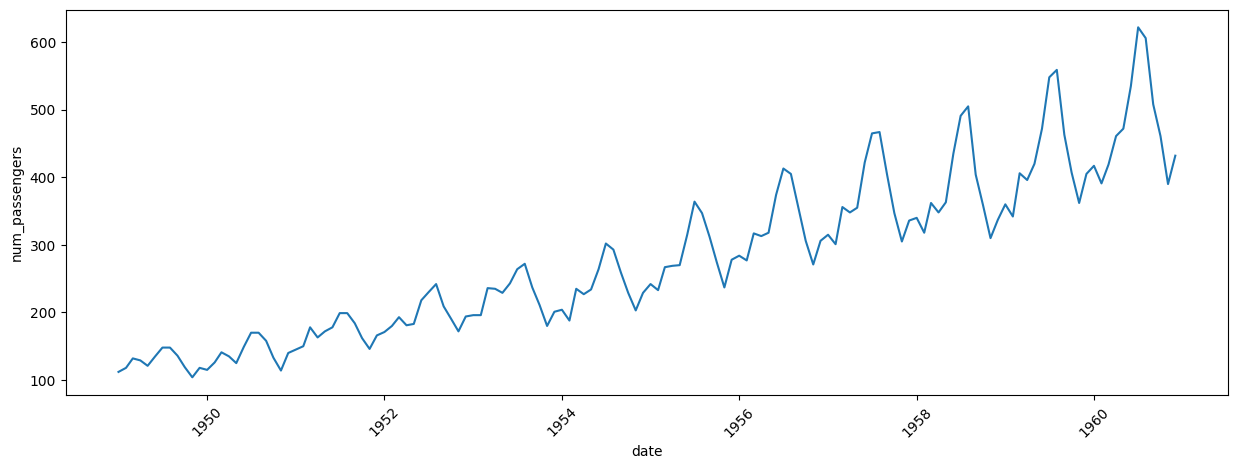

In [5]:
plot_lineplot_time_series(air_passengers, x="date", y="num_passengers")

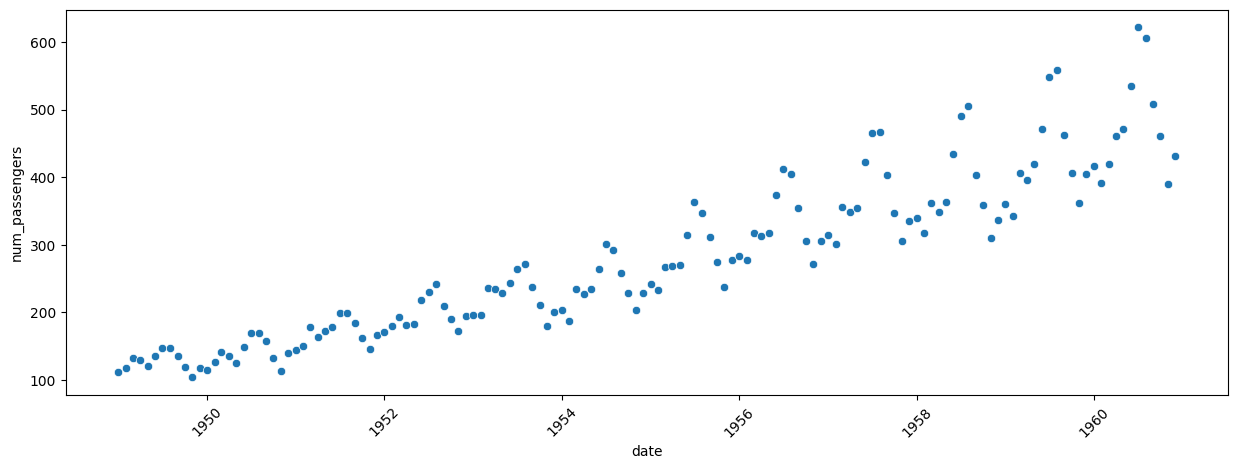

In [6]:
plot_scatter_time_series(air_passengers, x="date", y="num_passengers")

### What happens when we have missing data?

As mentioned before, the lineplot can create misleading visual effects if missing data is present.

In [7]:
available_months = range(0, 7)
air_passengers_with_missing_data = air_passengers.loc[
    air_passengers.date.dt.month.isin(available_months)
]

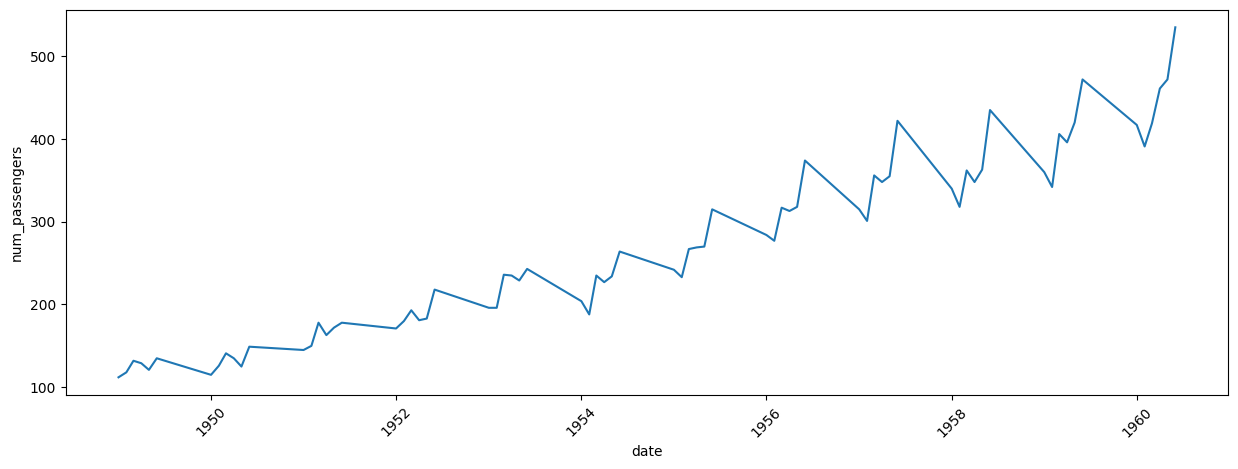

In [8]:
plot_lineplot_time_series(
    air_passengers_with_missing_data, x="date", y="num_passengers"
)

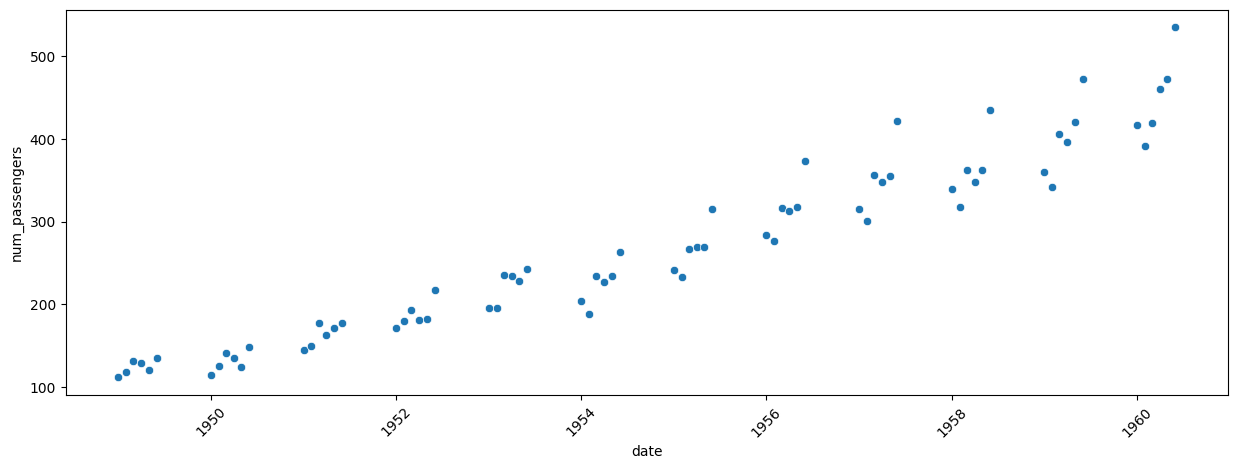

In [9]:
plot_scatter_time_series(air_passengers_with_missing_data, x="date", y="num_passengers")

# 2. Components of Time Series

## 2.1 Trend, Seasonality and Noise

Time Series can be decomposed in:
- Trend
- Seasonality
- Noise

To extract these components, we can leverage libraries such as statsmodels, which does the heavy lifting for us.

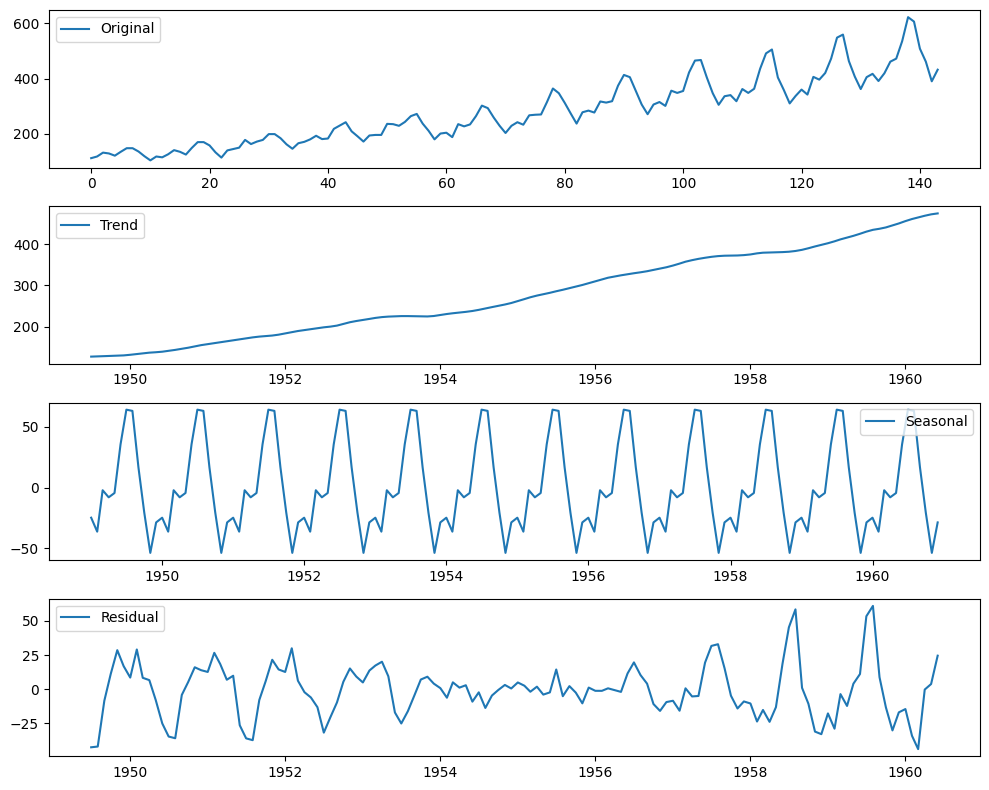

In [10]:
# Decompose the seasonal data
result = seasonal_decompose(
    air_passengers.set_index("date")["num_passengers"], model="additive"
)

# Plot the decomposed components
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(air_passengers["num_passengers"], label="Original")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label="Trend")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label="Seasonal")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label="Residual")
plt.legend()

plt.tight_layout()
plt.show()

## 2.2. Stationarity

Stationarity measures if the time series statistical properties (like mean, variance, and autocorrelation) do not change over time.

In this section, we will test both the Augmented Dickey-Fuller (ADF) Test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test.
For it to be stationary:
- ADF p-value < 0.05
- KPSS p-value > 0.05 (trend-stationary)

In [11]:
# ADF Test
result_adf = adfuller(air_passengers["num_passengers"], autolag="AIC")
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])
print("Critical Values:")
for key, value in result_adf[4].items():
    print(f"\t{key}: {value}")

# KPSS Test
result_kpss = kpss(air_passengers["num_passengers"], regression="c")
print("\nKPSS Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])
print("Critical Values:")
for key, value in result_kpss[3].items():
    print(f"\t{key}: {value}")

ADF Statistic: 0.8153688792060447
p-value: 0.9918802434376409
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598

KPSS Statistic: 1.6513122354165206
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Users/miguelcachosoblechero/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


We can apply transformations to make the time series stationary, such as differentiation.

In [12]:
# ADF Test
result_adf = adfuller(air_passengers["num_passengers"].diff().dropna(), autolag="AIC")
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])
print("Critical Values:")
for key, value in result_adf[4].items():
    print(f"\t{key}: {value}")

# KPSS Test
result_kpss = kpss(air_passengers["num_passengers"].diff().dropna(), regression="c")
print("\nKPSS Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])
print("Critical Values:")
for key, value in result_kpss[3].items():
    print(f"\t{key}: {value}")

ADF Statistic: -2.8292668241699794
p-value: 0.054213290283828236
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598

KPSS Statistic: 0.023897614400183967
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Users/miguelcachosoblechero/.pyenv/versions/3.9.18/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# 2.3. Self-Correlation

Self-correlation refers to the extend past values affect and define present values. Two plots can be generated to evaluate the self-correlation of a time series.
- Autocorrelation Function (ACF) - It plots the autocorrelation of a time series with its lags.
- Partial Autocorrelation Function (PACF) - It measures the correlation between a time series and its lagged values after removing the effects of intermediate lagged values.


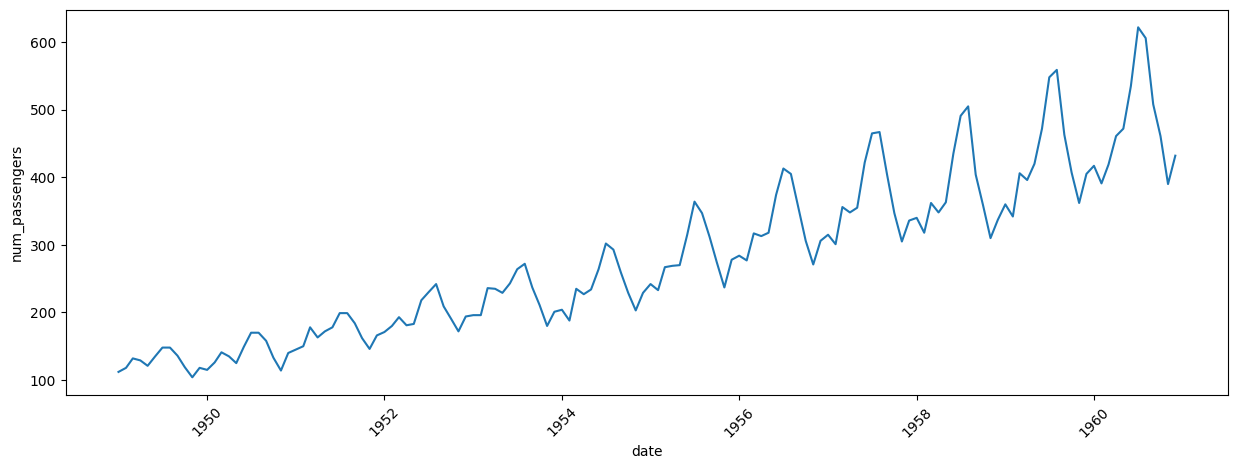

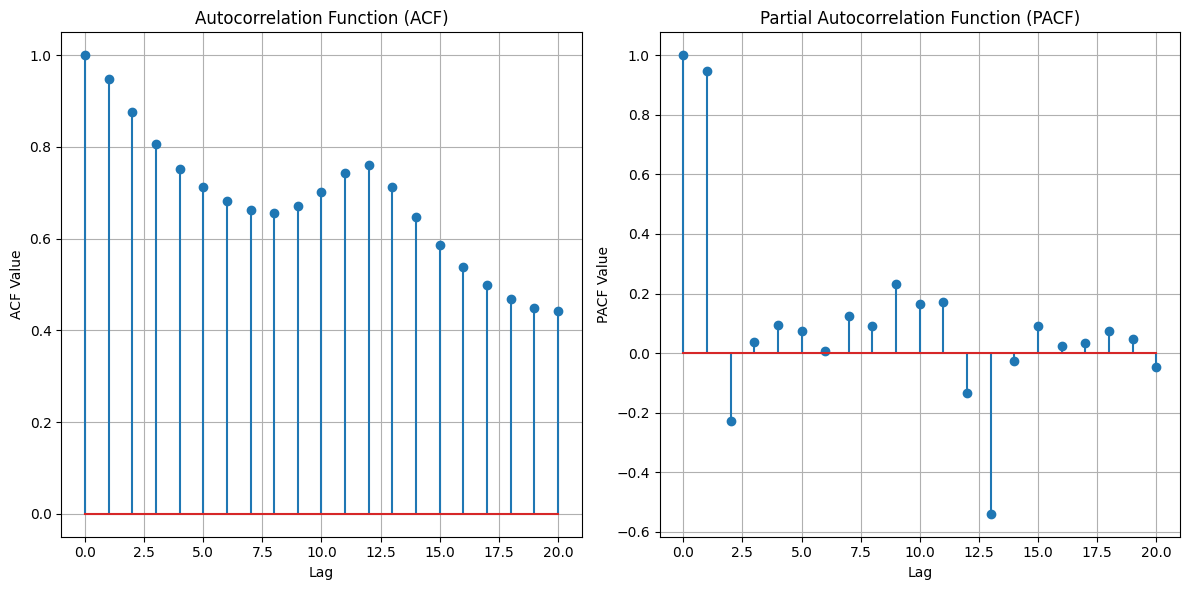

In [50]:
plot_lineplot_time_series(air_passengers, "date", "num_passengers")

# Compute the Autocorrelation Function (ACF)
acf = sm.tsa.acf(air_passengers.num_passengers.values, nlags=20, fft=False)

# Compute the Partial Autocorrelation Function (PACF)
pacf = sm.tsa.pacf(air_passengers.num_passengers.values, nlags=20, method=None)

# Plot the ACF and PACF
plt.figure(figsize=(12, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plt.stem(acf)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF Value")
plt.grid(True)

# Plot PACF
plt.subplot(1, 2, 2)
plt.stem(pacf)
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("PACF Value")
plt.grid(True)

plt.tight_layout()
plt.show()

From these ACF and PACF graphs, we can extract the following insights:
- Most points are correlated with each other, which indicates that numbers from the same season are likely to have similar values.
- The PACF shows a peak on month 13, where the trend is inversed. This indicates a yearly seasonality.

# 3. Data Wrangling in Time Series

# 3.1. Resampling

These methods modify the sampling frequency of the time series. 

## 3.1.1. Downsampling
Downsampling reduces the sampling frequency, using a variety of methods:
- Mean: Take the average of a period
- Sum: Accumulate values. This is not suitable for all measurements
- Median: Take the median of a period
- Max: Take the max of a period

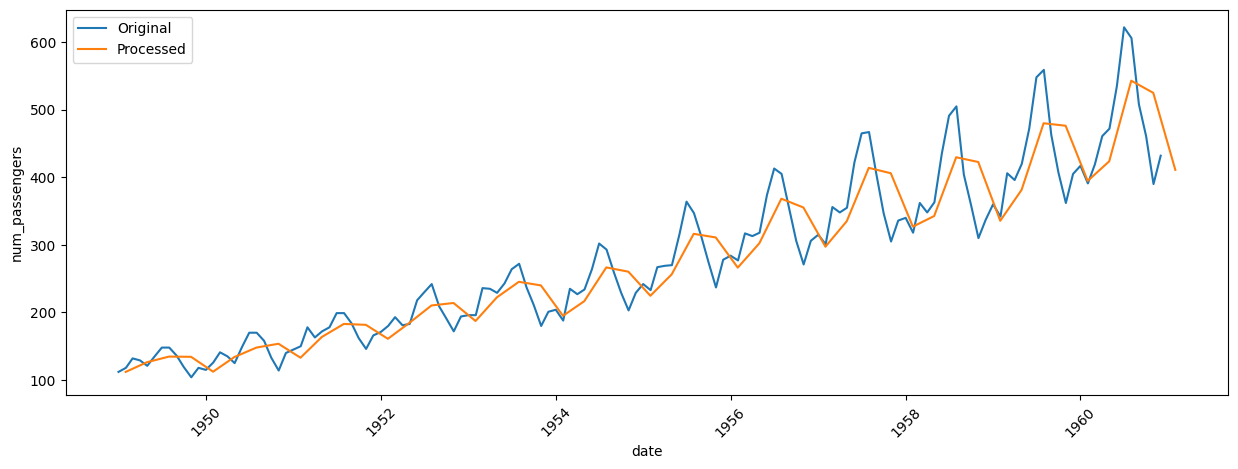

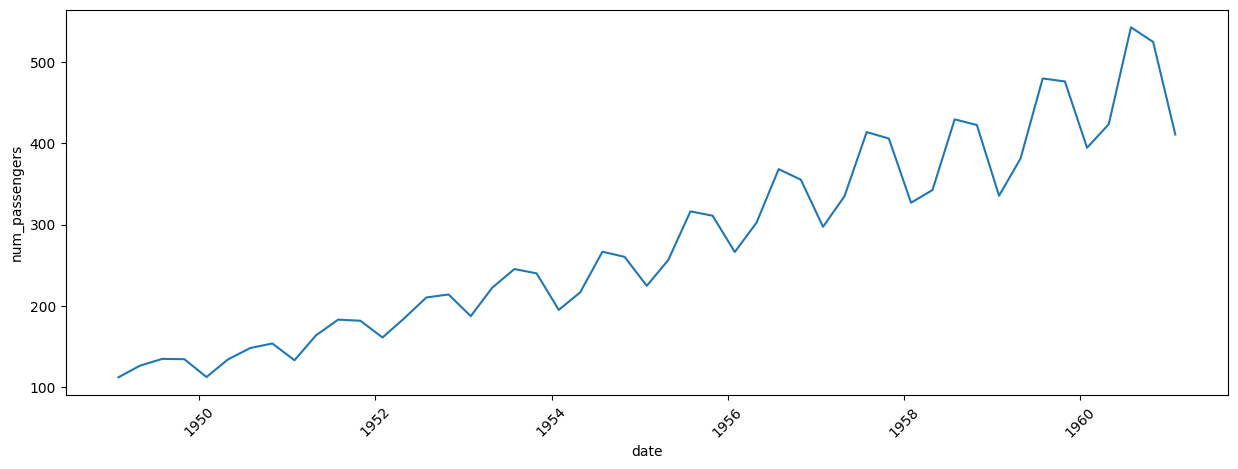

In [56]:
air_passengers_downsampled = (
    air_passengers.set_index("date").resample("3M").mean()
)  # '3M' stands for 3 months frequency, and mean() computes average
plot_lineplot_two_timeseries(
    data_original=air_passengers,
    x_original="date",
    y_original="num_passengers",
    data_processed=air_passengers_downsampled,
    x_processed="date",
    y_processed="num_passengers",
)
plot_lineplot_time_series(air_passengers_downsampled, "date", "num_passengers")

## 3.1.2. Upsampling
Upsampling creates new samples from the existing ones, using a variety of strategies:
- Imputation using forward-fill: Fill new samples with past values
- Interpolation: Fill new samples with the interpolated values between the two samples.

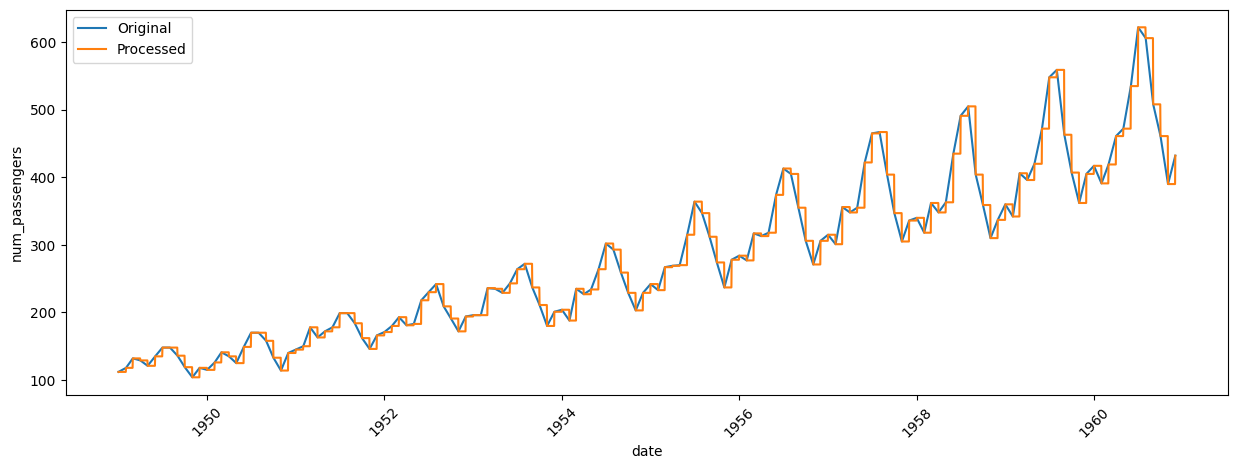

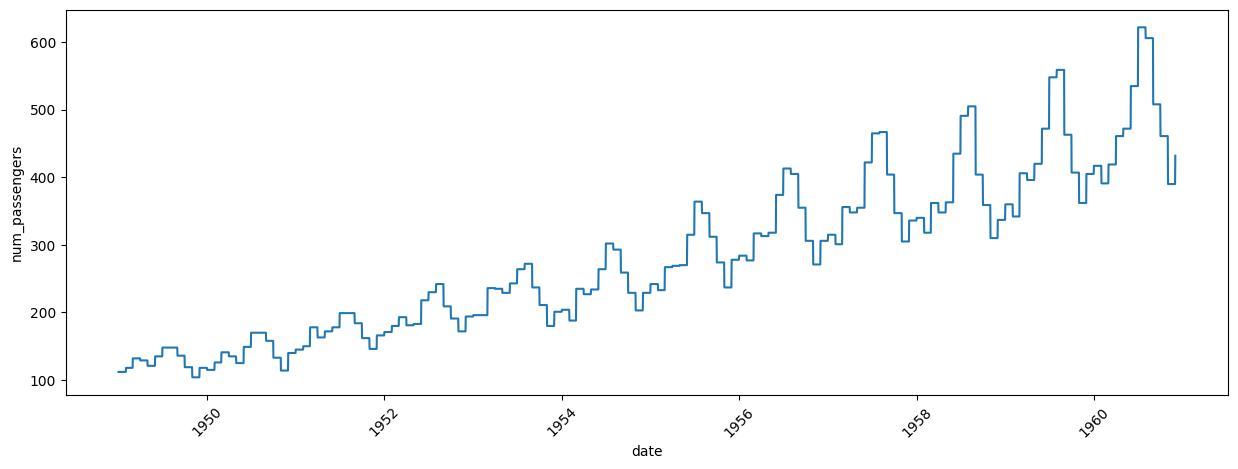

In [57]:
air_passengers_upsampled = (
    air_passengers.set_index("date").resample("D").ffill().reset_index()
)
plot_lineplot_two_timeseries(
    data_original=air_passengers,
    x_original="date",
    y_original="num_passengers",
    data_processed=air_passengers_upsampled,
    x_processed="date",
    y_processed="num_passengers",
)
plot_lineplot_time_series(air_passengers_upsampled, "date", "num_passengers")

# 3.2. Smoothing

This techniques eliminate the high frequency components (i.e. spikes and abnormal values) by averaging over a window.
I explore two main strategies:
- Moving average, using:
    - Trailing Moving Average - Using N past samples
    - Centered Moving Average - Centering the window on the sample, using N/2 samples forwards and backwards. CAREFUL: This can lead to lookahead.
    - Leading Moving Average - Using next N samples. CAREFUL: This can lead to lookahead.
- Exponential smoothing: Uses a weighted average approach. The most recent observation is given the most weight, and as you go back in time, the weights decrease exponentially.

### Moving Average

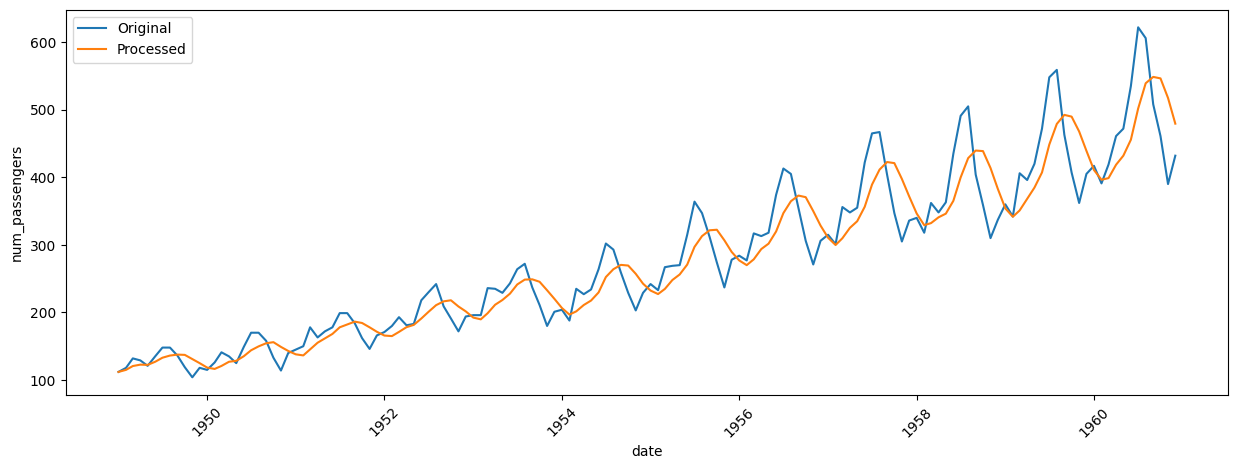

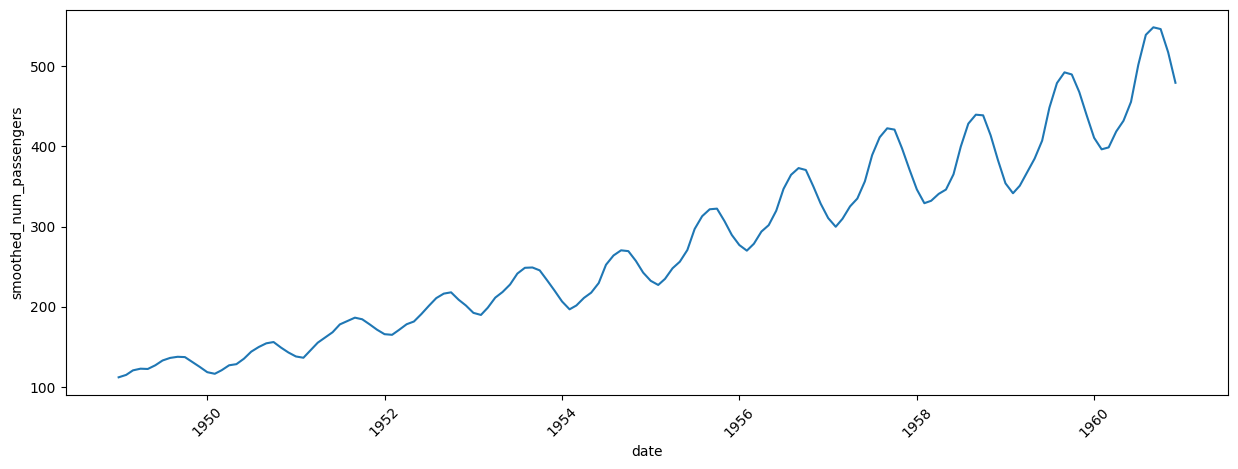

In [58]:
air_passengers["smoothed_num_passengers"] = (
    air_passengers["num_passengers"].rolling(window=5, min_periods=1).mean()
)
plot_lineplot_two_timeseries(
    data_original=air_passengers,
    x_original="date",
    y_original="num_passengers",
    data_processed=air_passengers,
    x_processed="date",
    y_processed="smoothed_num_passengers",
)
plot_lineplot_time_series(air_passengers, "date", "smoothed_num_passengers")

### Exponential Smoothing

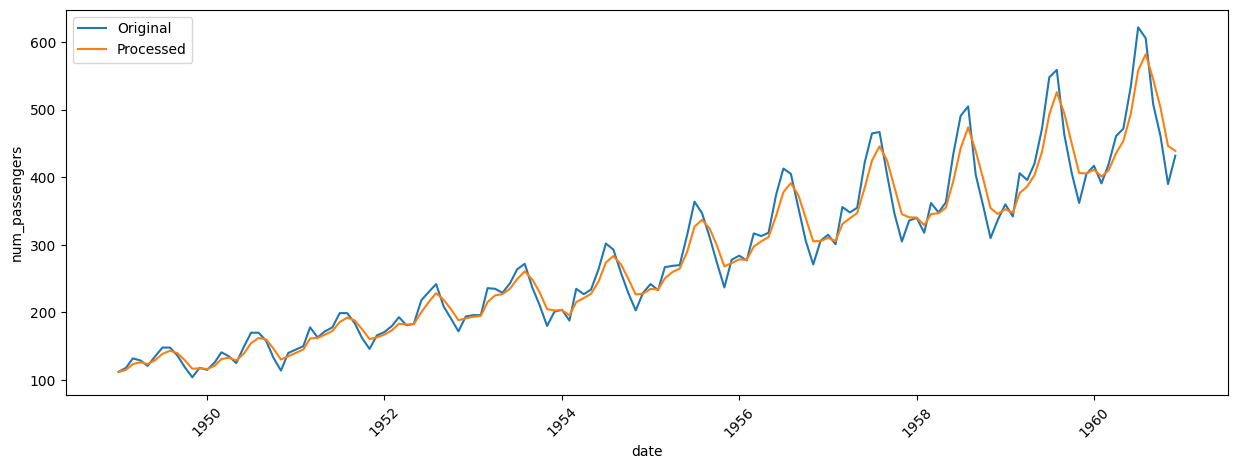

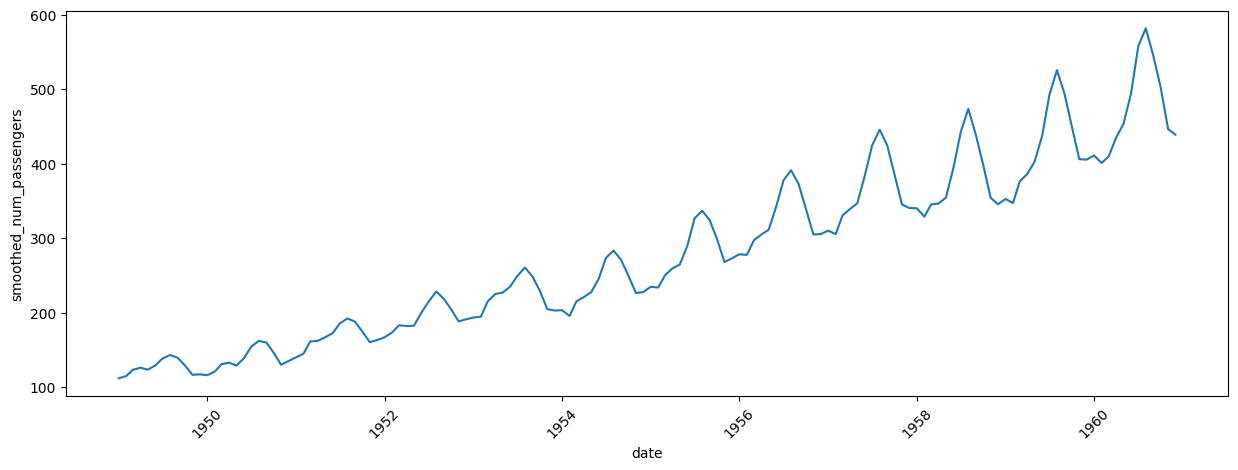

In [61]:
# Perform exponential smoothing
alpha = 0.5
air_passengers["smoothed_num_passengers"] = (
    air_passengers["num_passengers"]
    .ewm(alpha=alpha, adjust=False, ignore_na=True)
    .mean()
)
plot_lineplot_two_timeseries(
    data_original=air_passengers,
    x_original="date",
    y_original="num_passengers",
    data_processed=air_passengers,
    x_processed="date",
    y_processed="smoothed_num_passengers",
)
plot_lineplot_time_series(air_passengers, "date", "smoothed_num_passengers")

# Appendix

## Sine Waveform with ADF / PADF

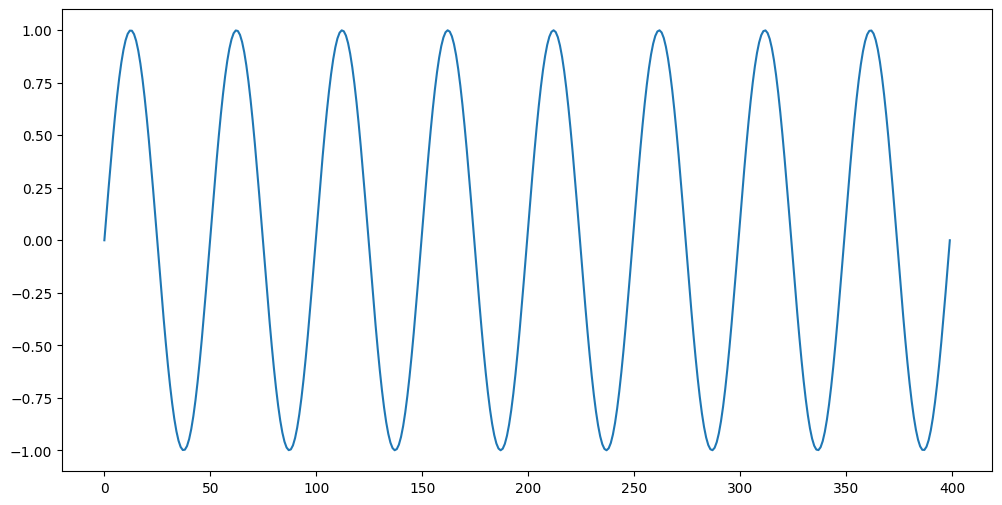

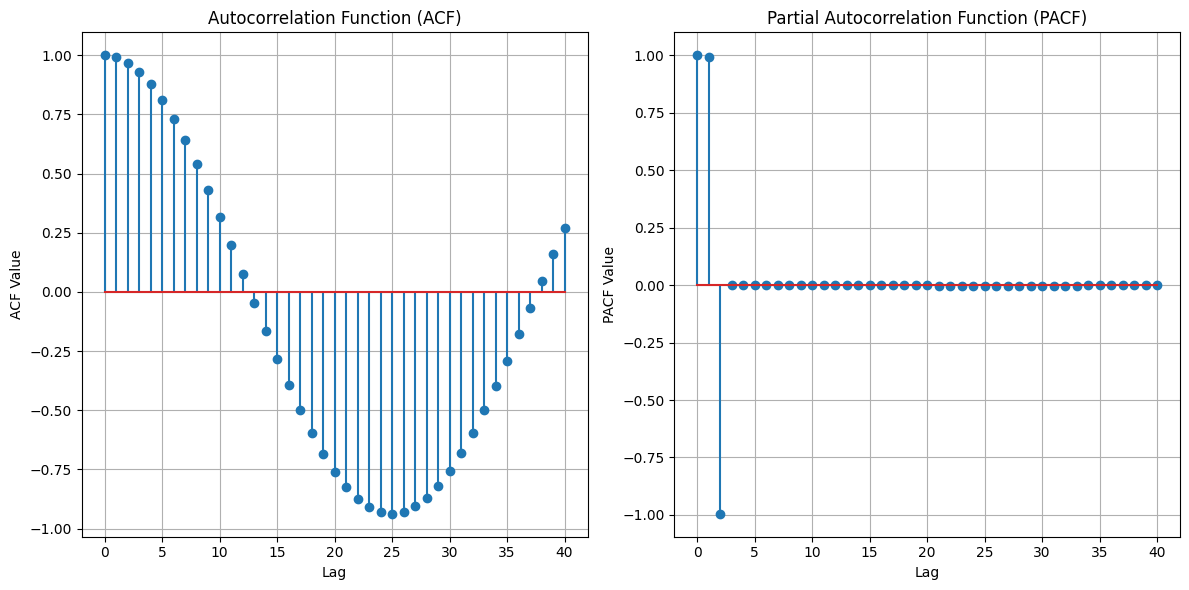

In [48]:
# Define the range of x values
x = np.linspace(0, 16 * np.pi, 400)
y = np.sin(x)

# Plot the ACF and PACF
plt.figure(figsize=(12, 6))
plt.plot(y)

# Compute the Autocorrelation Function (ACF)
acf = sm.tsa.acf(y, nlags=40, fft=True)

# Compute the Partial Autocorrelation Function (PACF)
pacf = sm.tsa.pacf(y, nlags=40, method=None)

# Plot the ACF and PACF
plt.figure(figsize=(12, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plt.stem(acf)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF Value")
plt.grid(True)

# Plot PACF
plt.subplot(1, 2, 2)
plt.stem(pacf)
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("PACF Value")
plt.grid(True)

plt.tight_layout()
plt.show()